# Test for a poly-prism data

This code calculates the amplitude of anomalous field trough an equivalent layer for a total field anomaly produced by polygonal prisms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
import mag_sphere_functions as mfun
% matplotlib inline

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


### Polygonal prisms

In [2]:
inc, dec = -60., 50. # inclination and declination of regional field
incs, decs = 70., -50.      # wrong direction or remanent

In [3]:
verts = [[-1000, 3000], [1000, 3000], [3000, 0], [1000, -3000], [-1000, -3000], [-3000, 0]]

model = [PolygonalPrism(verts, 100, 3000, props={'magnetization': utils.ang2vec(3, inc, dec)})]

### Observation points

In [4]:
#area over which the data are calculated
#x minimum, x maximum, y minimum and y maximum
area = [-10000, 10000, -10000, 10000] 

#number of data along the y and x directions
shape = (80,50)

#total number of data
N = shape[0]*shape[1]

#coordinates x and y of the data
x = np.linspace(area[0],area[1],shape[0]) # points in x
y = np.linspace(area[2],area[3],shape[0]) # points in y
xp,yp = np.meshgrid(x,y)    # creating mesh points
xp = xp.ravel()
yp = yp.ravel()

#vertical coordinates of the data
zp = -350. - 500.*utils.gaussian2d(xp, yp, 17000, 21000, 21000, 18500, angle=21) # relief

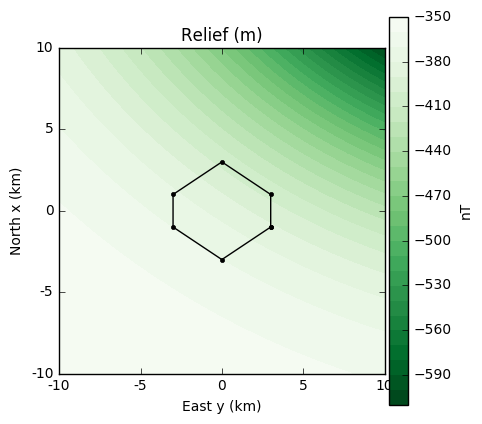

In [5]:
mpl.figure(figsize=(5,5))
mpl.title("Relief (m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, zp,(80,80),30, cmap=mpl.cm.Greens_r)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=1.0).set_label('nT')
for p in model:
    mpl.polygon(p, '.-k', xy2ne=True)
#mpl.savefig('model-polyprism.png', dpi=300)
mpl.m2km()
mpl.show()

### Total field anomaly (TFA) for polygonal prisms (fatiando)

In [6]:
tfat = polyprism.tf(xp, yp, zp, model, inc, dec)

### Adding noise

In [7]:
noise_tfa = np.random.normal(loc=0., scale=5., size=shape[0]*shape[0]) 

In [8]:
tfat = tfat + noise_tfa

### TFA data using a layer with a different magnetic direction

In [9]:
h = np.zeros(xp.size) + 200  # layer depth
A_tf = mfun.sm_tf_sphere(xp, yp, zp, xp, yp, h ,inc,dec,inc,dec)

In [10]:
I = np.identity(xp.size)
f0 = np.trace(np.dot(A_tf.T, A_tf))/xp.size
u0 = 0.0001

In [11]:
vp = np.linalg.solve(np.dot(A_tf.T,A_tf) + u0*f0*I,np.dot(A_tf.T,tfat))

In [12]:
tf = np.dot(A_tf,vp)

<function matplotlib.pyplot.show>

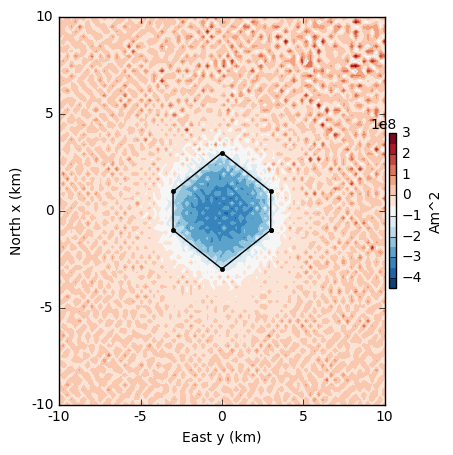

In [13]:
mpl.figure(figsize=(5,5))
mpl.contourf(yp, xp, vp,(80,80), 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('Am^2')
for p in model:
    mpl.polygon(p, '.-k', xy2ne=True)
#mpl.savefig('polyprism-induced-samedirec-reg/proplayer-polyprism.png', pad_inches=0.0)
mpl.show

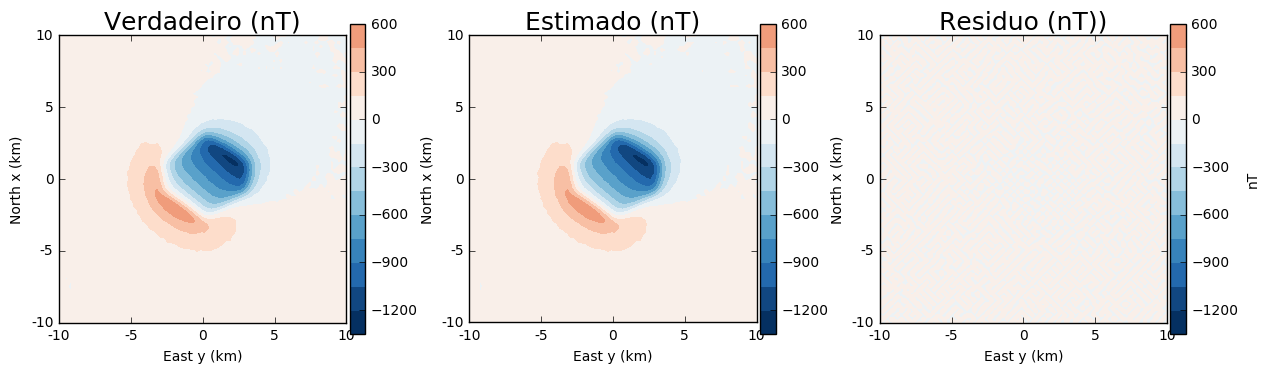

In [14]:
mpl.figure(figsize=(15,10))
ranges = np.abs([tfat.min(),tfat.max(),
                tf.min(),tf.max()]).max()
mpl.subplot(1,3,1)
mpl.title("Verdadeiro (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, tfat,(80,80), 15,vmin=-ranges,vmax=ranges, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4)
mpl.m2km()
mpl.subplot(1,3,2)
mpl.title("Estimado (nT)", fontsize = 18)
mpl.axis('scaled')
mpl.contourf(yp, xp, tf,(80,80),nlevels, 15,vmin=-ranges,vmax=ranges, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4)
mpl.subplot(1,3,3)
mpl.title("Residuo (nT))", fontsize = 18)
mpl.axis('scaled')
mpl.contourf(yp, xp, tfat - tf,(80,80),nlevels, 15,vmin=-ranges,vmax=ranges, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
#mpl.savefig('polyprism-induced-samedirec-reg/tfa-polyprism.png', pad_inches=0.0)
mpl.show()


### True amplitude of anomalous magnetic field (AMF)

In [15]:
BTB_true = np.sqrt(polyprism.bx(xp,yp,zp,model)**2 + \
                   polyprism.by(xp,yp,zp,model)**2 + \
                   polyprism.bz(xp,yp,zp,model)**2)

### AMF data using a layer with a different magnetic direction

In [16]:
A_bx = mfun.sm_bx_sphere(xp, yp, zp, xp, yp, h, inc, dec)

Bx_layer_fd = np.dot(A_bx,vp)

In [17]:
A_by = mfun.sm_by_sphere(xp, yp, zp, xp, yp, h, inc, dec)

By_layer_fd = np.dot(A_by,vp)

In [18]:
A_bz = mfun.sm_bz_sphere(xp, yp, zp, xp, yp, h, inc, dec)

Bz_layer_fd = np.dot(A_bz,vp)

In [19]:
BTB_layer_fd = np.sqrt(Bx_layer_fd**2 + By_layer_fd**2 + Bz_layer_fd**2)

In [20]:
#A_btb = mfun.sm_btb_sphere(xp, yp, zp, xp, yp, h, incs, decs)

In [21]:
#vp_btb = vp*vp

In [22]:
#btb = np.dot(A_btb,vp_btb)/200.

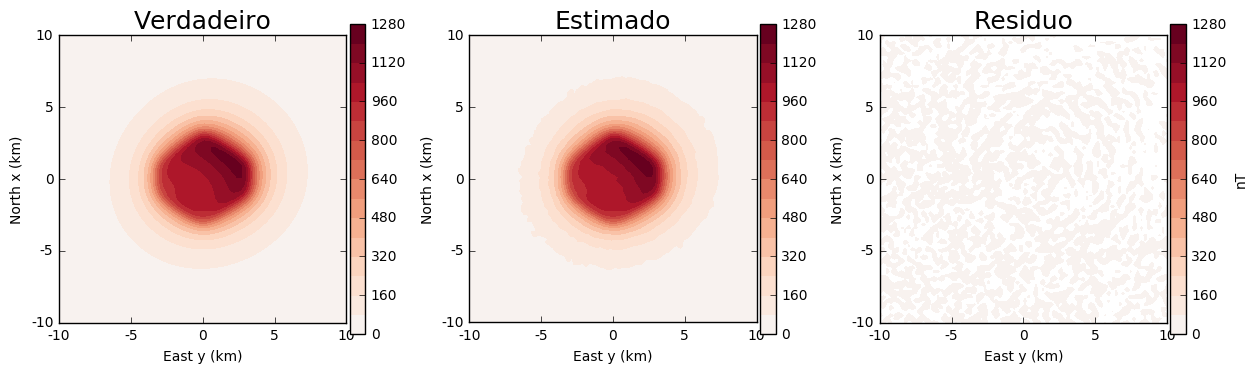

In [23]:
mpl.figure(figsize=(15,10))

ranges = np.abs([BTB_true.min(),BTB_true.max(),
                BTB_layer_fd.min(),BTB_layer_fd.max()]).max()
mpl.subplot(1,3,1)
mpl.title("Verdadeiro", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, BTB_true,(80,80), 15,vmin=-ranges,vmax=ranges, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4)
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Estimado", fontsize = 18)
mpl.axis('scaled')
mpl.contourf(yp, xp, BTB_layer_fd,(80,80),nlevels, 15,vmin=-ranges,vmax=ranges, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4)

mpl.subplot(1,3,3)
mpl.title("Residuo", fontsize = 18)
mpl.axis('scaled')
mpl.contourf(yp, xp, BTB_true - BTB_layer_fd,(80,80),nlevels, 15,vmin=-ranges,vmax=ranges, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')

#mpl.savefig('polyprism-induced-samedirec-reg/afm-polyprism.png', pad_inches=0.0)
mpl.show()


In [24]:
def residual(do,dp):
    r = do - dp
    r_mean = np.mean(r)
    r_std = np.std(r)
    r_norm = (r - r_mean)/r_std
    return r_norm, r_mean, r_std

In [25]:
r_norm, r_mean, r_std = residual(tfat, tf)

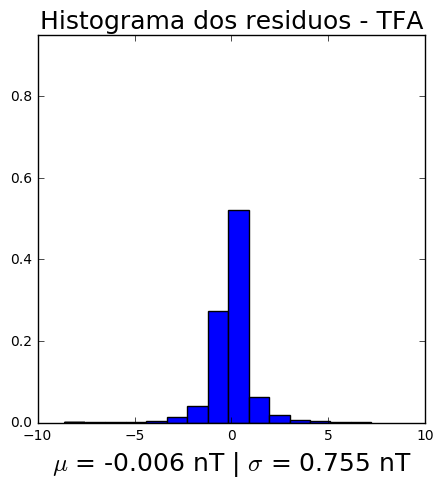

In [26]:
mpl.figure(figsize=(5,5))
mpl.xlabel('$\mu$ = %.3f nT | $\sigma$ = %.3f nT' % (r_mean, r_std), fontsize = 18)
nbins = int((np.max(r_norm) - np.min(r_norm)))
mpl.hist(r_norm,bins=nbins,normed=True)
mpl.ylim(0.,.95)
mpl.xlim(-10., 10.)
mpl.title('Histograma dos residuos - TFA', fontsize = 18)
#mpl.savefig('polyprism-induced-samedirec-reg/hist-amf.png', pad_inches=0.0)
mpl.show()
